In [1]:
# for use in tutorial and development; do not include this `sys.path` change in production:
import sys ; sys.path.insert(0, "../")

# demo: TextGraphs + LLMs to construct a 'lemma graph'

_TextGraphs_ library is intended for iterating through a sequence of paragraphs.

## environment

In [2]:
from IPython.display import display, HTML, Image, SVG
import pathlib
import typing

from icecream import ic
from pyinstrument import Profiler
import matplotlib.pyplot as plt
import pandas as pd
import pyvis
import spacy

import textgraphs

In [3]:
%load_ext watermark

In [4]:
%watermark

Last updated: 2024-01-13T13:12:02.111588-08:00

Python implementation: CPython
Python version       : 3.10.11
IPython version      : 8.20.0

Compiler    : Clang 13.0.0 (clang-1300.0.29.30)
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit



In [5]:
%watermark --iversions

matplotlib: 3.8.2
textgraphs: 0.3.2.dev3+gaea63b7.d20240108
pyvis     : 0.3.2
sys       : 3.10.11 (v3.10.11:7d4cc5aa85, Apr  4 2023, 19:05:19) [Clang 13.0.0 (clang-1300.0.29.30)]
spacy     : 3.7.2
pandas    : 2.1.4



## parse a document

provide the source text

In [6]:
SRC_TEXT: str = """                                                                                                                      
Werner Herzog is a remarkable filmmaker and an intellectual originally from Germany, the son of Dietrich Herzog.
After the war, Werner fled to America to become famous.
"""

set up the statistical stack profiling

In [7]:
profiler: Profiler = Profiler()
profiler.start()

set up the `TextGraphs` pipeline

In [8]:
tg: textgraphs.TextGraphs = textgraphs.TextGraphs(
    factory = textgraphs.PipelineFactory(
        spacy_model = textgraphs.SPACY_MODEL,
        ner = None,
        kg = textgraphs.KGWikiMedia(
            spotlight_api = textgraphs.DBPEDIA_SPOTLIGHT_API,
            dbpedia_search_api = textgraphs.DBPEDIA_SEARCH_API,
            dbpedia_sparql_api = textgraphs.DBPEDIA_SPARQL_API,
    		wikidata_api = textgraphs.WIKIDATA_API,
            min_alias = textgraphs.DBPEDIA_MIN_ALIAS,
            min_similarity = textgraphs.DBPEDIA_MIN_SIM,
        ),
        infer_rels = [
    		textgraphs.InferRel_OpenNRE(
                model = textgraphs.OPENNRE_MODEL,
                max_skip = textgraphs.MAX_SKIP,
                min_prob = textgraphs.OPENNRE_MIN_PROB,
    		),
            textgraphs.InferRel_Rebel(
                lang = "en_XX",
                mrebel_model = textgraphs.MREBEL_MODEL,
            ),
        ],
    ),
)

pipe: textgraphs.Pipeline = tg.create_pipeline(
    SRC_TEXT.strip(),
)

## visualize the parse results

In [9]:
spacy.displacy.render(
    pipe.ner_doc,
    style = "ent",
    jupyter = True,
)

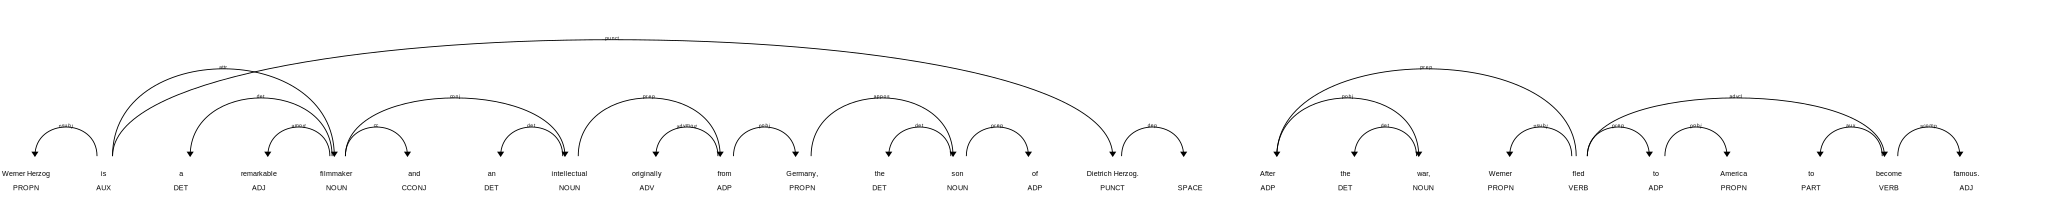

In [10]:
parse_svg: str = spacy.displacy.render(
    pipe.ner_doc,
    style = "dep",
    jupyter = False,
)

display(SVG(parse_svg))

## collect graph elements from the parse

In [11]:
tg.collect_graph_elements(
    pipe,
    debug = False,
)

In [12]:
ic(len(tg.nodes.values()));
ic(len(tg.edges.values()));

ic| len(tg.nodes.values()): 36
ic| len(tg.edges.values()): 42


## perform entity linking

In [13]:
tg.perform_entity_linking(
    pipe,
    debug = False,
)

## infer relations

In [14]:
inferred_edges: list = await tg.infer_relations_async(
    pipe,
    debug = False,
)

inferred_edges

[Edge(src_node=0, dst_node=10, kind=<RelEnum.INF: 2>, rel='https://schema.org/nationality', prob=1.0, count=1),
 Edge(src_node=15, dst_node=0, kind=<RelEnum.INF: 2>, rel='https://schema.org/children', prob=1.0, count=1),
 Edge(src_node=27, dst_node=22, kind=<RelEnum.INF: 2>, rel='https://schema.org/event', prob=1.0, count=1)]

## construct a lemma graph

In [15]:
tg.construct_lemma_graph(
    debug = False,
)

## extract ranked entities

In [16]:
tg.calc_phrase_ranks(
    pr_alpha = textgraphs.PAGERANK_ALPHA,
    debug = False,
)

show the resulting entities extracted from the document

In [17]:
df: pd.DataFrame = tg.get_phrases_as_df()
df

,node_id,text,pos,label,count,weight
0,0,Werner Herzog,PROPN,dbr:Werner_Herzog,1,0.080547
1,10,Germany,PROPN,dbr:Germany,1,0.080437
2,15,Dietrich Herzog,PROPN,dbo:Person,1,0.079048
3,27,America,PROPN,dbr:United_States,1,0.079048
4,24,Werner,PROPN,dbo:Person,1,0.077633
5,4,filmmaker,NOUN,owl:Thing,1,0.076309
6,22,war,NOUN,owl:Thing,1,0.076309
7,32,a remarkable filmmaker,noun_chunk,None,1,0.076077
8,7,intellectual,NOUN,owl:Thing,1,0.074725
9,13,son,NOUN,owl:Thing,1,0.074725


## visualize the lemma graph

In [18]:
render: textgraphs.RenderPyVis = tg.create_render()

pv_graph: pyvis.network.Network = render.render_lemma_graph(
    debug = False,
)

initialize the layout parameters

In [19]:
pv_graph.force_atlas_2based(
    gravity = -38,
    central_gravity = 0.01,
    spring_length = 231,
    spring_strength = 0.7,
    damping = 0.8,
    overlap = 0,
)

pv_graph.show_buttons(filter_ = [ "physics" ])
pv_graph.toggle_physics(True)

In [20]:
pv_graph.prep_notebook()
pv_graph.show("tmp.fig01.html")

tmp.fig01.html


## generate a word cloud

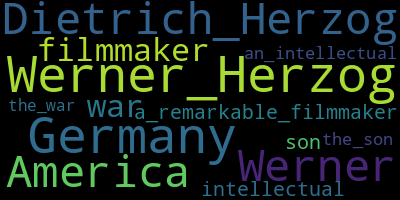

In [21]:
wordcloud = render.generate_wordcloud()
display(wordcloud.to_image())

## cluster communities in the lemma graph

In the tutorial
<a href="https://towardsdatascience.com/how-to-convert-any-text-into-a-graph-of-concepts-110844f22a1a" target="_blank">"How to Convert Any Text Into a Graph of Concepts"</a>, 
Rahul Nayak uses the
<a href="https://en.wikipedia.org/wiki/Girvan%E2%80%93Newman_algorithm"><em>girvan-newman</em></a>
algorithm to split the graph into communities, then clusters on those communities.
His approach works well for unsupervised clustering of key phrases which have been extracted from many documents.
In contrast, Nayak was working with entities extracted from "chunks" of text, not with a text graph.

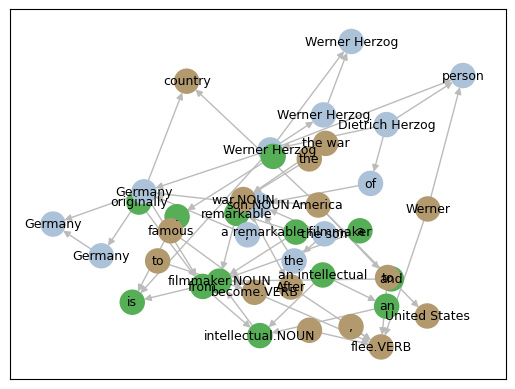

In [22]:
render.draw_communities();

## graph of relations transform

Show a transformed graph, based on _graph of relations_ (see: `lee2023ingram`)

In [23]:
graph: textgraphs.GraphOfRelations = textgraphs.GraphOfRelations(
    tg
)

graph.seeds()
graph.construct_gor()

In [24]:
scores: typing.Dict[ tuple, float ] = graph.get_affinity_scores()
pv_graph: pyvis.network.Network = graph.render_gor_pyvis(scores)

pv_graph.force_atlas_2based(
    gravity = -38,
    central_gravity = 0.01,
    spring_length = 231,
    spring_strength = 0.7,
    damping = 0.8,
    overlap = 0,
)

pv_graph.show_buttons(filter_ = [ "physics" ])
pv_graph.toggle_physics(True)

pv_graph.prep_notebook()
pv_graph.show("tmp.fig02.html")

tmp.fig02.html


*What does this transform provide?*

By using a _graph of relations_ dual representation of our graph data, first and foremost we obtain a more compact representation of the relations in the graph, and means of making inferences (e.g., _link prediction_) where there is substantially more invariance in the training data.

Also recognize that for a parse graph of a paragraph in the English language, the most interesting nodes will probably be either subjects (`nsubj`) or direct objects (`pobj`). Here in the _graph of relations_ we see illustrated how the important details from _entity linking_ tend to cluster near either `nsubj` or `pobj` entities, connected through punctuation. This is not as readily observed in the earlier visualization of the _lemma graph_.

## extract as RDF triples

Extract the nodes and edges which have IRIs, to create an "abstraction layer" as a semantic graph at a higher level of detail above the _lemma graph_:

In [25]:
triples: str = tg.extract_rdf()
ic(triples);

ic| triples: ('@base <https://github.com/DerwenAI/textgraphs/ns/> .
             '
              '@prefix dbo: <http://dbpedia.org/ontology/> .
             '
              '@prefix dbr: <http://dbpedia.org/resource/> .
             '
              '@prefix schema: <https://schema.org/> .
             '
              '@prefix skos: <http://www.w3.org/2004/02/skos/core#> .
             '
              '@prefix wd_ent: <http://www.wikidata.org/entity/> .
             '
              '
             '
              'dbr:Germany skos:definition "Germany (German: Deutschland, German '
              'pronunciation: [ˈdɔʏtʃlant]), constitutionally the Federal"@en ;
             '
              '    skos:prefLabel "Germany"@en .
             '
              '
             '
              'dbr:United_States skos:definition "The United States of America (USA), '
              'commonly known as the United States (U.S. or US) or America"@en ;
             '
              '    skos:prefLabel "Unite

## statistical stack profile instrumentation

In [26]:
profiler.stop()

In [27]:
profiler.print()


  _     ._   __/__   _ _  _  _ _/_   Recorded: 13:12:02  Samples:  12494
 /_//_/// /_\ / //_// / //_'/ //     Duration: 63.071    CPU time: 79.760
/   _/                      v4.6.1

Program: /Users/paco/src/textgraphs/venv/lib/python3.10/site-packages/ipykernel_launcher.py -f /Users/paco/Library/Jupyter/runtime/kernel-21c48172-c498-4e47-889b-254035b61b7d.json

63.071 _UnixSelectorEventLoop._run_once  asyncio/base_events.py:1832
└─ 63.069 Handle._run  asyncio/events.py:78
      [13 frames hidden]  asyncio, ipykernel, IPython
         42.842 ZMQInteractiveShell.run_ast_nodes  IPython/core/interactiveshell.py:3394
         ├─ 21.069 <module>  ../ipykernel_75549/1708547378.py:1
         │  ├─ 16.395 InferRel_Rebel.__init__  textgraphs/rel.py:121
         │  │  └─ 16.285 pipeline  transformers/pipelines/__init__.py:531
         │  │        [39 frames hidden]  transformers, torch, <built-in>, json
         │  ├─ 3.191 PipelineFactory.__init__  textgraphs/pipe.py:434
         │  │  └─ 3.174

## outro

_\[ more parts are in progress, getting added to this demo \]_